Group 1 / Coulton Theuer, JingJie Wan, Tammy Yang, Nicole Chen


---


#**Tie-breaker: Using language models to quantify gender bias in sports journalism**
(Liye Fu and Cristian Danescu-Niculescu-Mizil and Lillian Lee, 2016)


---



#**Step1: BACKGROUND SETTING**

In [174]:
# install KenLM
! pip install https://github.com/kpu/kenlm/archive/master.zip
! sudo apt -y install build-essential cmake libboost-system-dev libboost-thread-dev libboost-program-options-dev libboost-test-dev libeigen3-dev zlib1g-dev libbz2-dev liblzma-dev
! wget -O - https://kheafield.com/code/kenlm.tar.gz | tar xz
! mkdir kenlm/build && cd kenlm/build && cmake .. && make -j2
! ls kenlm/build/bin

  Using cached https://github.com/kpu/kenlm/archive/master.zip
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
build-essential is already the newest version (12.9ubuntu3).
libboost-program-options-dev is already the newest version (1.74.0.3ubuntu7).
libboost-system-dev is already the newest version (1.74.0.3ubuntu7).
libboost-thread-dev is already the newest version (1.74.0.3ubuntu7).
libbz2-dev is already the newest version (1.0.8-5build1).
liblzma-dev is already the newest version (5.2.5-2ubuntu1).
libboost-test-dev is already the newest version (1.74.0.3ubuntu7).
libeigen3-dev is already the newest version (3.4.0-2ubuntu2).
cmake is already the newest version (3.22.1-1ubuntu1.22.04.1).
zlib1g-dev is already the newest version (1:1.2.11.dfsg-2ubuntu9.2).
0 upgraded, 0 newly installed, 0 to remove and 32

In [205]:
# required packages
import json
import requests
import pandas as pd
import kenlm
import sys
import os
import tqdm
import spacy
import math
from collections import Counter

In [206]:
# enable dataframe display format in this ipynb
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [177]:
# connet to tutorial drive folder for data files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [178]:
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = ''
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', 'si699_teaching_tutorial', 'tennis_data', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
sys.path.append(GOOGLE_DRIVE_PATH)
commentary_data_path = os.path.join(GOOGLE_DRIVE_PATH, 'text_commentaries.json')

In [179]:
# read in games commentaries
data = open(commentary_data_path, 'r')
text_commentries = json.load(data)
pd_text_commentaries = pd.DataFrame(text_commentries)
pd_text_commentaries.head()

,commentary,scoreline,gender
0,Makarova slumps back into making unforced erro...,Sharapova 6-3* Makarova,F
1,Just look in her match with Heather Watson las...,Williams 3-6 2-1* Azarenka,F
2,Sharapova saves a break point to hold her serv...,Williams *0-2 Sharapova,F
3,"Erakovic is looking superb behind her serve, a...",Robson 1-4* Erakovic,F
4,She can't save another one and Williams is now...,Williams 2-6 5-1* Lisicki,F


In [207]:
# load nlp package spacy for sentenizer function
from spacy.lang.en import English
from spacy.scorer import Scorer

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("sentencizer")

In [181]:
# save sentenized commentaries
with open('sent_train.txt', 'w') as f:
    for i in pd_text_commentaries['commentary']:
        doc = nlp(i)
        for sent in doc.sents:
            f.write(sent.text.lower() + '\n')

In [182]:
# transform data into kenlm required format
! kenlm/build/bin/lmplz -o 5 < "sent_train.txt" > "train.arpa"
! kenlm/build/bin/build_binary train.arpa train.binary

=== 1/5 Counting and sorting n-grams ===
Reading /content/sent_train.txt
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
****************************************************************************************************
Unigram tokens 175716 types 7775
=== 2/5 Calculating and sorting adjusted counts ===
Chain sizes: 1:93300 2:1062191296 3:1991608704 4:3186573824 5:4647087104
Statistics:
1 7775 D1=0.643092 D2=1.00824 D3+=1.30707
2 53870 D1=0.754407 D2=1.10534 D3+=1.43692
3 109164 D1=0.846708 D2=1.19023 D3+=1.39132
4 137092 D1=0.915332 D2=1.28837 D3+=1.6413
5 144053 D1=0.946495 D2=1.37505 D3+=1.55333
Memory estimate for binary LM:
type       kB
probing  9763 assuming -p 1.5
probing 11552 assuming -r models -p 1.5
trie     4393 without quantization
trie     2273 assuming -q 8 -b 8 quantization 
trie     4007 assuming -a 22 array pointer compression
trie     1888 assuming -a 22 -q 8 -b 8 array pointer compression and quantization
=== 3

In [183]:
# apply kenlm model on our commentaries data
model = kenlm.Model('train.binary')
print(model.score('this is a sentence.', bos = True, eos = True))
print(model.score('game', bos = True, eos = True))

-10.348812103271484
-5.038731575012207


**The scores represent the log likelihood (negative) of the given text according to the language model.**

*Higher (less negative) scores indicate more probable sentences according to the language model, whereas lower (more negative) scores indicate less probable sentences.*


---



# **Step2: GAME LANGUAGE MODEL**

In [184]:
# calculate perplexity
def perplexity_score(query):
  return model.perplexity(query)

In [185]:
print(f"Low perplexity questions - \nWhat about your serve, Rafa?: {perplexity_score('What about your serve, Rafa?')}")
print(f"The tiebreak, was that the key to the match?: {perplexity_score('The tiebreak, was that the key to the match?')} \n")
print(f"High perplexity questions -  \nWho designed your clothes today? : {perplexity_score('Who designed your clothes today?')}")
print(f"Do you normally watch horror films to relax?: {perplexity_score('Do you normally watch horror films to relax?')}")

Low perplexity questions - 
What about your serve, Rafa?: 6007.399629655489
The tiebreak, was that the key to the match?: 502.87260511339133 

High perplexity questions -  
Who designed your clothes today? : 17948.953341974695
Do you normally watch horror films to relax?: 12527.278528622757




---



# **Step3: EXPERIMENTS**

## 1. Main Result -- Male vs. Female

In [186]:
# construct the interview questions into a dataframe.
# Each row stands for one question of one player.
transcripts_data_path = os.path.join(GOOGLE_DRIVE_PATH, 'transcripts_matchinfo.json')
t_data = open(transcripts_data_path, 'r')
transcripts = json.load(t_data)
transcript_df = pd.DataFrame(transcripts).T

In [187]:
transcript_df['question_number'] = transcript_df['QandA'].apply(lambda x: len(x))
transcript_df_expanded = transcript_df.explode('QandA')
transcript_df_expanded[['question', 'answer']] = pd.DataFrame(transcript_df_expanded['QandA'].tolist(), index=transcript_df_expanded.index)
df = transcript_df_expanded[['question', 'answer', 'date', 'gender', 'player', 'ranking', 'opponent', 'result', 'stage', 'tournament', 'tournament_type']]
df.head()

,question,answer,date,gender,player,ranking,opponent,result,stage,tournament,tournament_type
0,That last set seemed like a faultless performa...,"Yeah, I served extremely well, and then the tw...",2015-06-21,M,Andy Murray,3,Kevin Anderson,1,The Final,AEGON CHAMPIONSHIPS,ATP500
0,"Did playing the semifinal, finishing that off ...","No, I don't think so. You know, it was an unfo...",2015-06-21,M,Andy Murray,3,Kevin Anderson,1,The Final,AEGON CHAMPIONSHIPS,ATP500
0,Is that difficult mentally as much as physical...,"Yeah, well, there is a lot of things that you...",2015-06-21,M,Andy Murray,3,Kevin Anderson,1,The Final,AEGON CHAMPIONSHIPS,ATP500
0,You said on TV I think you said you felt bette...,"Well, I think you just have to improve; otherw...",2015-06-21,M,Andy Murray,3,Kevin Anderson,1,The Final,AEGON CHAMPIONSHIPS,ATP500
0,The last time that you won this tournament you...,"Yeah, but that means nothing, really. You know...",2015-06-21,M,Andy Murray,3,Kevin Anderson,1,The Final,AEGON CHAMPIONSHIPS,ATP500


In [188]:
# apply perplexity calculater
df['perplexity'] = df['question'].apply(perplexity_score)
df.head()

<ipython-input-188-f69d6ed7866c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['perplexity'] = df['question'].apply(perplexity_score)


,question,answer,date,gender,player,ranking,opponent,result,stage,tournament,tournament_type,perplexity
0,That last set seemed like a faultless performa...,"Yeah, I served extremely well, and then the tw...",2015-06-21,M,Andy Murray,3,Kevin Anderson,1,The Final,AEGON CHAMPIONSHIPS,ATP500,2265.549668
0,"Did playing the semifinal, finishing that off ...","No, I don't think so. You know, it was an unfo...",2015-06-21,M,Andy Murray,3,Kevin Anderson,1,The Final,AEGON CHAMPIONSHIPS,ATP500,954.232958
0,Is that difficult mentally as much as physical...,"Yeah, well, there is a lot of things that you...",2015-06-21,M,Andy Murray,3,Kevin Anderson,1,The Final,AEGON CHAMPIONSHIPS,ATP500,1310.254706
0,You said on TV I think you said you felt bette...,"Well, I think you just have to improve; otherw...",2015-06-21,M,Andy Murray,3,Kevin Anderson,1,The Final,AEGON CHAMPIONSHIPS,ATP500,3902.455463
0,The last time that you won this tournament you...,"Yeah, but that means nothing, really. You know...",2015-06-21,M,Andy Murray,3,Kevin Anderson,1,The Final,AEGON CHAMPIONSHIPS,ATP500,662.420755


## Compare male and female players' perplexities by questions

In [189]:
# Perform Mann-Whitney U test
from scipy.stats import mannwhitneyu
statistic, p_value = mannwhitneyu(df[df['gender'] == 'M']['perplexity'], df[df['gender'] == 'F']['perplexity'])

print(f"Mann-Whitney U Statistic: {statistic} \n")
print(f"P-Value: {p_value} \n")

# Check for statistical significance
alpha = 0.05
if p_value < alpha:
    print("The difference is statistically significant. Male questions are more game-related.")
else:
    print("There is no statistically significant difference between male and female questions.")

Mann-Whitney U Statistic: 827480822.5 

P-Value: 0.01766126180457031 

The difference is statistically significant. Male questions are more game-related.


## Compare female and male players which have at least 10 questions in the dataset (perplexities by player)

In [190]:
# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu([1,2,33], [4,2,4])

print(f"Mann-Whitney U Statistic: {statistic} \n")
print(f"P-Value: {p_value} \n")

alpha = 0.05
if p_value < alpha:
    print("The difference is statistically significant. Male questions are more game-related.")
else:
    print("There is no statistically significant difference between male and female questions.")

Mann-Whitney U Statistic: 3.5 

P-Value: 0.8221867672380183 

There is no statistically significant difference between male and female questions.


## 2. Relationship with Other Factors

In [191]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [192]:
# Example documents
documents = [q for q in df['question']]

# Tokenize documents and remove stop words
stop_words = set(stopwords.words('english'))
tokenized_documents = [
    [word.lower() for word in word_tokenize(doc) if word.lower() not in stop_words]
    for doc in documents
]


# Replace capitalized words and phrases with "<NOUN>"
for doc in tokenized_documents:
    for i, word in enumerate(doc):
        if word.istitle() and word.lower() not in stop_words:
            doc[i] = "<NOUN>"

In [193]:
# Calculate Document Frequency (DF)
document_frequency = Counter()
for doc in tokenized_documents:
    document_frequency.update(set(doc))

# Total number of documents
total_documents = len(tokenized_documents)

# Calculate IDF for each term
idf_values = {term: math.log(total_documents / (document_frequency[term] + 1)) for term in document_frequency}

In [194]:
# Tokenize questions and remove stop words for questions
def tokenize_and_remove_stopwords(question):
    tokens = [word.lower() for word in word_tokenize(question) if word.lower() not in stop_words]
    return set(tokens)

df['tokenized_question'] = df['question'].apply(tokenize_and_remove_stopwords)


## **2.1 Typical vs. Atypical Questions**

In [195]:
# Calculate atypicality score for each question
def compute_atypicality_score(tokenized_question, idf_values):
    if not tokenized_question:
        return None
    num_words = len(tokenized_question)
    score = sum(idf_values.get(word, 0) for word in tokenized_question) / num_words
    return score

df['atypicality_score'] = df['tokenized_question'].apply(lambda x: compute_atypicality_score(x, idf_values))

# Print or use the transcript_df_expanded with atypicality scores as needed
df[['question', 'atypicality_score']].head()

,question,atypicality_score
0,That last set seemed like a faultless performa...,3.659324
0,"Did playing the semifinal, finishing that off ...",3.614959
0,Is that difficult mentally as much as physical...,3.883315
0,You said on TV I think you said you felt bette...,4.840166
0,The last time that you won this tournament you...,3.057796


In [211]:
# test example questions:
print('Typical:')
print(df[['question', 'atypicality_score']][df['question'] == "Have you played each other before?"])
print('Atypical:')
print(df[['question', 'atypicality_score']][df['question'] == "Are you a vodka drinker?"])

Typical:
                                question  atypicality_score
5016  Have you played each other before?            1.59648
Atypical:
                      question  atypicality_score
2575  Are you a vodka drinker?           6.580595


### Count the atypicality of each question

In [196]:
cutoff = df['atypicality_score'].mean()
df['atypicality'] = df['atypicality_score'].apply(lambda x: 'Atypical' if x > cutoff else 'Typical')

# Test gender difference between typical and atypical groups
# Atypical group
male_atypical = df[(df['gender'] == 'M') & (df['atypicality_score'] > cutoff)]
female_atypical = df[(df['gender'] == 'F') & (df['atypicality_score']  > cutoff)]
statistic, p_value = mannwhitneyu(male_atypical['perplexity'], female_atypical['perplexity'])
print(f'Mann-Whitney U test p-value of atypcial group: {p_value}')


Mann-Whitney U test p-value of atypcial group: 3.114719928349132e-05


In [197]:
# Typical group
male_typical = df[(df['gender'] == 'M') & (df['atypicality_score'] <= cutoff)]
female_typical = df[(df['gender'] == 'F') & (df['atypicality_score']  <= cutoff)]
statistic, p_value = mannwhitneyu(male_typical['perplexity'], female_typical['perplexity'])
print(f'Mann-Whitney U test p-value of typical group: {p_value}')

Mann-Whitney U test p-value of typical group: 0.5979210176093868


<Axes: xlabel='atypicality', ylabel='perplexity'>

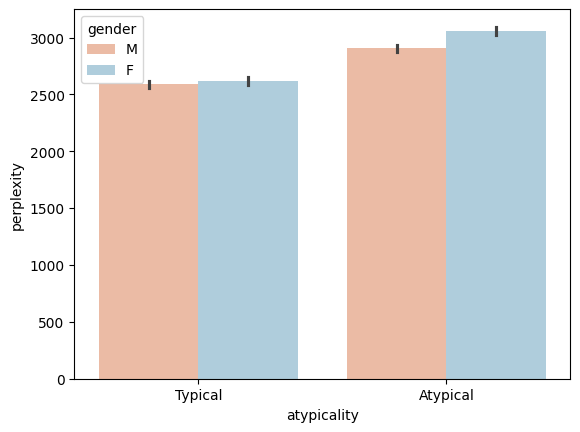

In [198]:
import matplotlib.pyplot as plt
import seaborn as sns
#create bar chart
sns.barplot(x='atypicality', y='perplexity', hue='gender', data=df, palette='RdBu')

In [199]:
# Test gender difference between top10 and rest players
# Label for plot
df['top10'] = df['ranking'].apply(lambda x: 'Top10' if x <= 10 else 'Rest')
# Top10 group
male_top10 = df[(df['gender'] == 'M') & (df['ranking'] <= 10)]
female_top10 = df[(df['gender'] == 'F') & (df['ranking']  <= 10)]
statistic, p_value = mannwhitneyu(male_top10['perplexity'], female_top10['perplexity'])
print(f'Mann-Whitney U test p-value of top 10 players group: {p_value}')

# Rest group
male_rest = df[(df['gender'] == 'M') & (df['ranking'] > 10)]
female_rest = df[(df['gender'] == 'F') & (df['ranking'] > 10)]
statistic, p_value = mannwhitneyu(male_rest['perplexity'], female_rest['perplexity'])
print(f'Mann-Whitney U test p-value of rest group: {p_value}')

Mann-Whitney U test p-value of top 10 group: 0.7062678440155711
Mann-Whitney U test p-value of rest group: 0.008823000524376021


<Axes: xlabel='top10', ylabel='perplexity'>

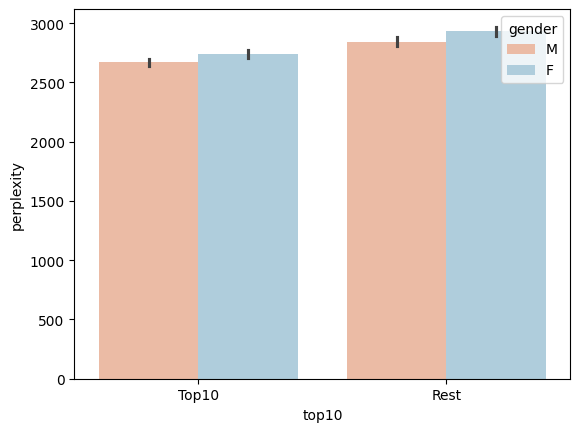

In [202]:
import matplotlib.pyplot as plt
import seaborn as sns
#create bar chart
sns.barplot(x='top10', y='perplexity', hue='gender', data=df, palette='RdBu')

In [ ]:
# win group
male_top10 = df[(df['gender'] == 'M') & (df['result'] == 1)]
female_top10 = df[(df['gender'] == 'F') & (df['result']  == 1)]
statistic, p_value = mannwhitneyu(male_top10['perplexity'], female_top10['perplexity'])
print(f'Mann-Whitney U test p-value of win group: {p_value}')

# lose group
male_rest = df[(df['gender'] == 'M') & (df['result'] == 0)]
female_rest = df[(df['gender'] == 'F') & (df['result'] == 0)]
statistic, p_value = mannwhitneyu(male_rest['perplexity'], female_rest['perplexity'])
print(f'Mann-Whitney U test p-value of lose group: {p_value}')

<Axes: xlabel='result', ylabel='perplexity'>

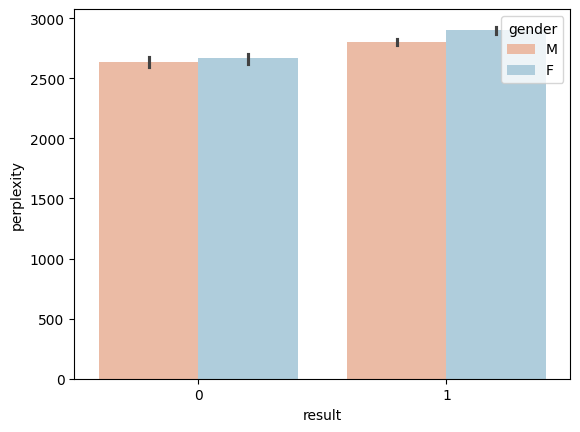

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns
#create bar chart
sns.barplot(x='result', y='perplexity', hue='gender', data=df, palette='RdBu')

# End of Tutorial